# Connected components

## Load dependencies

In [ ]:
import bisect

import networkx as nx
import pandas as pd
import seaborn as sns
import numpy as np
import dataframe_image as dfi
import itertools
from pathlib import Path

import config
from config import INTERACTOMES_PATH, DATA_REACTOME_PATH, genes, proteoforms, METHODS, PATHWAY_GRAPHS_PATH, SMALL_MOLECULES
from lib.networks import get_pathway_filenames
from lib.networks import get_interactomes, get_multiindex, create_pathway_interaction_networks
from lib.networks import get_json_filename, create_pathway_interaction_network, read_graph, replace_methods

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()


## Load Interactomes

In [2]:
index = get_multiindex()
interactomes_no_sm, interactomes_with_sm, interactomes_with_unique_sm = get_interactomes(DATA_REACTOME_PATH, INTERACTOMES_PATH)
interactomes = [interactomes_no_sm[genes], interactomes_no_sm[proteoforms], interactomes_with_sm[genes], interactomes_with_sm[proteoforms], interactomes_with_unique_sm[genes], interactomes_with_unique_sm[proteoforms]]

Reading participants of all reactions for level genes...
Reading participants of all reactions for level proteins...
Reading participants of all reactions for level proteoforms...
Reading participants of all reactions for level sm...
Reading components of all complexes for level genes...
Reading components of all complexes for level proteins...
Reading components of all complexes for level proteoforms...
Reading components of all complexes for level sm...
Reading interaction network for  at genes level, method no_sm...
Reading interaction network for  at proteins level, method no_sm...
Reading interaction network for  at proteoforms level, method no_sm...
Reading interaction network for  at genes level, method with_sm...
Reading interaction network for  at proteins level, method with_sm...
Reading interaction network for  at proteoforms level, method with_sm...
Reading interaction network for  at genes level, method with_unique_sm...
Reading interaction network for  at proteins level, 

# Metrics by Interactome

In [3]:
def getTuples(i):
    sizes = [len(c) / i.number_of_nodes() for c in sorted(nx.connected_components(i), key=len, reverse=True)]
    d = [(i.graph["method"], i.graph["level"], s) for s in sizes]
    return d


tuples = [getTuples(i) for i in interactomes]
data = list(itertools.chain.from_iterable(tuples))
df_cc = pd.DataFrame(data, columns=['Small Molecules', 'Entity Level', 'Size'])
# Number of connected components
# Size of the largest connected component
# Relative size of the largest connected component
# Average size of the connected components
# Size of the smallest component
# Number of isolated nodes

def getTuples(i):
    ccs_sizes = [len(c) for c in sorted(nx.connected_components(i), key=len, reverse=False)]
    num_ccs = len(ccs_sizes)

    return (
        i.graph["method"],
        i.graph["level"],
        num_ccs,
        ccs_sizes[-1],
        ccs_sizes[-1] / i.number_of_nodes(),
        sum(ccs_sizes) / len(ccs_sizes),
        ccs_sizes[0],
        0 if ccs_sizes[0] > 1 else bisect.bisect_left(ccs_sizes, 2, lo=0, hi=len(ccs_sizes))
    )


data = [getTuples(i) for i in interactomes]
columns = [
    'Method',
    'Level',
    'Num. CCs',
    'Size of LCC',
    'Relative size of LCC',
    'Average size of CCs',
    "Size of SCC",
    "Num. isolated nodes"
]
df_ccs_interactomes = pd.DataFrame.from_records(data, columns=columns, index=get_multiindex())
dfi.export(df_ccs_interactomes[columns[2:]], 'figures/table_interactomes_ccs.png')
df_ccs_interactomes[columns[2:]]

Num. CCs  Size of LCC  \
Small Molecules          Entity Level                          
Not Included             genes             1774         8967   
                         proteoforms       1819        12091   
Included                 genes              194        12792   
                         proteoforms        202        16053   
Reaction-Unique Included genes             2445        30153   
                         proteoforms       2480        33107   

                                       Relative size of LCC  \
Small Molecules          Entity Level                         
Not Included             genes                         0.82   
                         proteoforms                   0.85   
Included                 genes                         0.98   
                         proteoforms                   0.98   
Reaction-Unique Included genes                         0.74   
                         proteoforms                   0.76   

                                       Average size of CCs  Size of SCC  \
Small Molecules          Entity Level                                     
Not Included             genes                        6.19            1   
                         proteoforms                  7.83            1   
Included                 genes                       67.18            1   
                         proteoforms                 80.71            1   
Reaction-Unique Included genes                       16.60            1   
                         proteoforms                 17.68            1   

                                       Num. isolated nodes  
Small Molecules          Entity Level                       
Not Included             genes                        1665  
                         proteoforms                  1696  
Included                 genes                         164  
                         proteoforms                   171  
Reaction-Unique Included genes                        1160  
                         proteoforms                  1167

# Metrics by Pathway

## Select pathways with proteoforms with annotations

In [4]:
proteoforms_no_annotations = [node for node in interactomes_no_sm['proteoforms'].nodes if not any((c in {':', '-'}) for c in str(node))]
proteoforms_with_annotations = [node for node in interactomes_no_sm['proteoforms'].nodes if any((c in {':', '-'}) for c in str(node))]

pathways_map = nx.get_node_attributes(interactomes_no_sm[proteoforms], "pathways")
selected_pathways = set()

for proteoform in proteoforms_with_annotations:
    for pathway in pathways_map[proteoform]:
        selected_pathways.add(pathway)
print(f"There are {len(selected_pathways)} pathways with proteoforms with annotations.")
df_selected_pathways = pd.DataFrame(selected_pathways, columns=["Pathway"])
df_selected_pathways.sort_values(by=["Pathway"], inplace=True)
df_selected_pathways

There are 1119 pathways with proteoforms with annotations.


,Pathway
777,R-HSA-1059683
588,R-HSA-109704
978,R-HSA-110056
473,R-HSA-110312
523,R-HSA-110314
...,...
680,R-HSA-977347
979,R-HSA-977606
731,R-HSA-982772
1102,R-HSA-983231


## Calculate metrics by pathway

In [5]:
columns_for_pathways = [
    'Pathway',
    'Level',
    'Small Molecules',
    'Relative size LCC',
    'Avg. relative size CCs',
    'Relative size SCC',
    '# CCs',
    '# Isolated nodes',
    'Relative # Isolated nodes',
]


def get_pathway_tuples(pathway, pathway_graph):
    ccs_sizes = [len(cc) for cc in sorted(nx.connected_components(pathway_graph), key=len, reverse=False)]
    rel_ccs_sizes = [size / pathway_graph.number_of_nodes() for size in ccs_sizes]
    num_isolated_nodes = 0 if ccs_sizes[0] > 1 else bisect.bisect_left(ccs_sizes, 2, lo=0, hi=len(ccs_sizes))
    return (
        pathway,
        pathway_graph.graph["level"],
        pathway_graph.graph["method"],
        rel_ccs_sizes[-1],
        sum(rel_ccs_sizes) / len(rel_ccs_sizes),
        rel_ccs_sizes[0],
        len(ccs_sizes),
        num_isolated_nodes,
        num_isolated_nodes / len(ccs_sizes)
    )


data_pathways = []
for pathway in list(df_selected_pathways["Pathway"]):
    for method in METHODS:
        for level in [genes, proteoforms]:
            filename = get_json_filename(level, method, PATHWAY_GRAPHS_PATH, pathway)
            if not Path(filename).exists():
                create_pathway_interaction_network(pathway, level, method, PATHWAY_GRAPHS_PATH)
            G = read_graph(filename)
            if G.number_of_nodes() > 0:
                data_pathways.append(get_pathway_tuples(pathway, G))


## Create table with metrics by pathway

In [6]:
df_ccs_pathways = pd.DataFrame.from_records(data_pathways, columns=columns_for_pathways)
replace_methods(df_ccs_pathways)
df_ccs_pathways

,Pathway,Level,Small Molecules,Relative size LCC,Avg. relative size CCs,Relative size SCC,# CCs,# Isolated nodes,Relative # Isolated nodes
0,R-HSA-1059683,genes,Not Included,1.00,1.00,1.00,1,0,0.00
1,R-HSA-1059683,proteoforms,Not Included,1.00,1.00,1.00,1,0,0.00
2,R-HSA-1059683,genes,Included,1.00,1.00,1.00,1,0,0.00
3,R-HSA-1059683,proteoforms,Included,1.00,1.00,1.00,1,0,0.00
4,R-HSA-1059683,genes,Reaction-Unique Included,1.00,1.00,1.00,1,0,0.00
...,...,...,...,...,...,...,...,...,...
6709,R-HSA-983695,proteoforms,Not Included,0.91,0.33,0.01,3,1,0.33
6710,R-HSA-983695,genes,Included,1.00,1.00,1.00,1,0,0.00
6711,R-HSA-983695,proteoforms,Included,1.00,1.00,1.00,1,0,0.00
6712,R-HSA-983695,genes,Reaction-Unique Included,0.84,0.33,0.02,3,0,0.00


## Separate pathway metrics by small molecules handling

In [7]:
df_no_sm = df_ccs_pathways[(df_ccs_pathways['Small Molecules'] == "Not Included") & (df_ccs_pathways['Level'] == f"{genes}")]
df_with_sm = df_ccs_pathways[(df_ccs_pathways['Small Molecules'] == "Included") & (df_ccs_pathways['Level'] == f"{genes}")]
df_with_ru_sm =  df_ccs_pathways[(df_ccs_pathways['Small Molecules'] == "Reaction-Unique Included") & (df_ccs_pathways['Level'] == f"{genes}")]

## Calculate change in LCC by adding small molecules

In [8]:
df_no_sm_size_lcc = df_no_sm[['Pathway', 'Relative size LCC']]
df_no_sm_size_lcc.set_index('Pathway', inplace=True)

df_with_sm_size_lcc = df_with_sm[['Pathway', 'Relative size LCC']]
df_with_sm_size_lcc.set_index('Pathway', inplace=True)

result = pd.concat([df_no_sm_size_lcc, df_with_sm_size_lcc], axis=1)
result = result[~result.isnull().any(axis=1)]
result.columns = ["LCC size no sm", "LCC size with sm"]
result["Increase"] = result["LCC size with sm"]/result["LCC size no sm"]
result.sort_values(by=['Increase'], ascending=False, inplace=True)
result.head(10)

,LCC size no sm,LCC size with sm,Increase
Pathway,,,
R-HSA-70263,0.03,1.00,34.00
R-HSA-9753281,0.03,1.00,30.00
R-HSA-9749641,0.05,1.00,22.00
R-HSA-196757,0.06,1.00,17.00
R-HSA-2162123,0.07,1.00,15.00
R-HSA-109704,0.07,1.00,14.33
R-HSA-189451,0.07,1.00,14.00
R-HSA-1483213,0.08,1.00,13.00
R-HSA-2046106,0.08,1.00,13.00


## Calculate change in number of connected components by adding small molecules

In [9]:
df_no_sm = df_no_sm[(df_no_sm['Relative # Isolated nodes'] == 0)]
df_with_sm = df_with_sm[(df_with_sm['Relative # Isolated nodes'] == 0)]

df_no_sm_num_ccs = df_no_sm[['Pathway', '# CCs']]
df_no_sm_num_ccs.set_index('Pathway', inplace=True)

df_with_sm_num_ccs = df_with_sm[['Pathway', '# CCs']]
df_with_sm_num_ccs.set_index('Pathway', inplace=True)

result = pd.concat([df_no_sm_num_ccs, df_with_sm_num_ccs], axis=1)
result = result[~result.isnull().any(axis=1)]
result.columns = ["Num CCs no sm", "Num CCs with sm"]
result["Increase"] = result["Num CCs with sm"]/result["Num CCs no sm"]
result.sort_values(by=['Increase'], ascending=True, inplace=True)
result.head(10)

,Num CCs no sm,Num CCs with sm,Increase
Pathway,,,
R-HSA-5689880,12.00,1.00,0.08
R-HSA-8876725,8.00,1.00,0.12
R-HSA-445144,4.00,1.00,0.25
R-HSA-3000480,4.00,1.00,0.25
R-HSA-2871809,3.00,1.00,0.33
R-HSA-445355,3.00,1.00,0.33
R-HSA-381676,3.00,1.00,0.33
R-HSA-1445148,3.00,1.00,0.33
R-HSA-5607764,5.00,2.00,0.40


In [10]:
df_with_ru_sm_num_ccs = df_with_ru_sm[['Pathway', '# CCs']]
df_with_ru_sm_num_ccs.set_index('Pathway', inplace=True)

result = pd.concat([df_with_sm_num_ccs, df_with_ru_sm_num_ccs], axis=1)
result = result[~result.isnull().any(axis=1)]
result.columns = ["Num CCs with sm", "Num CCs with reaction-unique sm"]
result["Increase"] = result["Num CCs with reaction-unique sm"]/result["Num CCs with sm"]
result.sort_values(by=['Increase'], ascending=False, inplace=True)
result

,Num CCs with sm,Num CCs with reaction-unique sm,Increase
Pathway,,,
R-HSA-352230,1.00,26,26.00
R-HSA-2162123,1.00,25,25.00
R-HSA-70263,1.00,25,25.00
R-HSA-193368,1.00,23,23.00
R-HSA-9749641,1.00,22,22.00
...,...,...,...
R-HSA-373080,12.00,12,1.00
R-HSA-373752,3.00,3,1.00
R-HSA-373753,1.00,1,1.00


In [11]:
# df_no_sm_size_lcc = df_no_sm[['Pathway', 'Average relative size of connected components']]
# df_no_sm_size_lcc.set_index('Pathway', inplace=True)
# df_with_sm_size_cc = df_with_sm[['Pathway', 'Average relative size of connected components']]
# df_with_sm_size_cc.set_index('Pathway', inplace=True)


## Aggregate metrics of CCs for pathways

In [12]:
df_pathways_grouped = df_ccs_pathways.groupby(['Small Molecules', 'Level']).agg(
    {
        'Relative size LCC': ['mean'],
        'Avg. relative size CCs': ['mean'],
        'Relative size SCC': ['mean'],
        'Relative # Isolated nodes': ['mean']
    })
df_pathways_grouped.columns = [
    'Avg. Rel. Size of LCC',
    'Avg. Rel. Size of CCs',
    'Avg. Rel. Size of SCC',
    'Avg. Rel. Number of isolated nodes'
]
df_pathways_grouped = df_pathways_grouped.set_index(get_multiindex())
dfi.export(df_pathways_grouped, 'figures/table_pathways_ccs.png')
df_pathways_grouped

Avg. Rel. Size of LCC  \
Small Molecules          Entity Level                          
Not Included             genes                          0.91   
                         proteoforms                    0.91   
Included                 genes                          0.83   
                         proteoforms                    0.83   
Reaction-Unique Included genes                          0.83   
                         proteoforms                    0.83   

                                       Avg. Rel. Size of CCs  \
Small Molecules          Entity Level                          
Not Included             genes                          0.83   
                         proteoforms                    0.81   
Included                 genes                          0.72   
                         proteoforms                    0.71   
Reaction-Unique Included genes                          0.71   
                         proteoforms                    0.70   

                                       Avg. Rel. Size of SCC  \
Small Molecules          Entity Level                          
Not Included             genes                          0.77   
                         proteoforms                    0.76   
Included                 genes                          0.66   
                         proteoforms                    0.64   
Reaction-Unique Included genes                          0.64   
                         proteoforms                    0.62   

                                       Avg. Rel. Number of isolated nodes  
Small Molecules          Entity Level                                      
Not Included             genes                                       0.08  
                         proteoforms                                 0.08  
Included                 genes                                       0.20  
                         proteoforms                                 0.18  
Reaction-Unique Included genes                                       0.09  
                         proteoforms                                 0.09

## Change in isolated nodes when adding small molecules to pathways

In [13]:
df_no_sm = df_ccs_pathways[(df_ccs_pathways['Small Molecules'] == "Not Included") & (df_ccs_pathways['Level'] == f"{genes}")]
df_with_sm = df_ccs_pathways[(df_ccs_pathways['Small Molecules'] == "Included") & (df_ccs_pathways['Level'] == f"{genes}")]
df_with_ru_sm =  df_ccs_pathways[(df_ccs_pathways['Small Molecules'] == "Reaction-Unique Included") & (df_ccs_pathways['Level'] == f"{genes}")]

# df_no_sm = df_pathways_grouped[(df_pathways_grouped['Small Molecules'] == "Not Included") & (df_pathways_grouped['Entity Level'] == f"{genes}")]
# df_with_sm = df_pathways_grouped[(df_pathways_grouped['Small Molecules'] == "Included") & (df_pathways_grouped['Entity Level'] == f"{genes}")]
# df_with_sm

df_no_sm_isolated = df_no_sm[['Pathway', "# Isolated nodes"]]
df_no_sm_isolated.set_index('Pathway', inplace=True)
df_no_sm_isolated

df_with_sm_isolated = df_with_sm[['Pathway', "# Isolated nodes"]]
df_with_sm_isolated.set_index('Pathway', inplace=True)
df_with_sm_isolated

result = pd.concat([df_no_sm_isolated, df_with_sm_isolated], axis=1)
result = result[~result.isnull().any(axis=1)]
result.columns = ["Num isolated no sm", "Num isolated with sm"]
print(f"We considered {len(result)} pathways.")
print(f"In {np.count_nonzero(result['Num isolated no sm'] > result['Num isolated with sm'])} pathways there are less isolated nodes when we add small molecules to the network.")
print(f"In contrast, {np.count_nonzero(result['Num isolated no sm'] < result['Num isolated with sm'])} pathways there are more isolated nodes when adding small molecules.")

We considered 1119 pathways.
In 226 pathways there are less isolated nodes when we add small molecules to the network.
In contrast, 39 pathways there are more isolated nodes when adding small molecules.


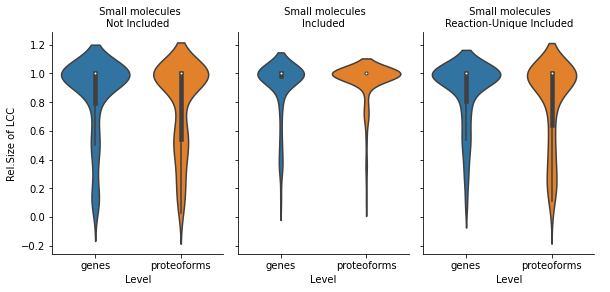

In [14]:
g = sns.catplot(x="Level", y='Relative size LCC',
                col="Small Molecules",
                data=df_ccs_pathways.sample(1000),
                kind="violin", split=True,
                order=[genes, proteoforms], col_order=SMALL_MOLECULES,
                height=4, aspect=.7);
# g.fig.suptitle("Small Molecules")
# g.fig.subplots_adjust(top=0.85)
g.set_titles(" Small molecules\n{col_name}")
g.set_axis_labels("Level", 'Rel.Size of LCC')
g.add_legend()

c:\Python310\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\Python310\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\Python310\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


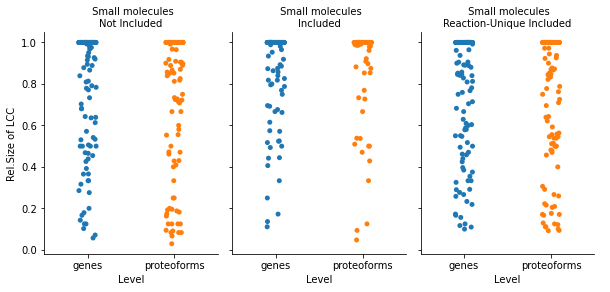

In [15]:
g = sns.catplot(x="Level", y='Relative size LCC',
                col="Small Molecules",
                data=df_ccs_pathways.sample(1000),
                kind="strip", split=True,
                order=[genes, proteoforms], col_order=SMALL_MOLECULES,
                height=4, aspect=.7);
# g.fig.suptitle("Small Molecules")
# g.fig.subplots_adjust(top=0.85)
g.set_titles(" Small molecules\n{col_name}")
g.set_axis_labels("Level", 'Rel.Size of LCC')
g.add_legend()

## Show examples of Pahtway CCs

In [16]:

n = 10
pathway_examples_isolated_nodes = set()
for pathway, filename in get_pathway_filenames(PATHWAY_GRAPHS_PATH, list(df_selected_pathways["Pathway"])):
    G = read_graph(filename)
    if G.number_of_nodes() < 20:
        ccs_sizes = [len(cc) for cc in sorted(nx.connected_components(G), key=len, reverse=False)]
        if ccs_sizes[0] == 1:
            prev = len(pathway_examples_isolated_nodes)
            pathway_examples_isolated_nodes.add(pathway)
            if len(pathway_examples_isolated_nodes) != prev:
                print(f"{pathway} CCs: {ccs_sizes}")
            if len(pathway_examples_isolated_nodes) == n: break;


R-HSA-110362 CCs: [1, 7]
R-HSA-111457 CCs: [1, 6]
R-HSA-112399 CCs: [1, 3, 3, 8]
R-HSA-1236382 CCs: [1, 1, 1, 1, 15]
R-HSA-1237044 CCs: [1, 1, 1, 1, 1, 1, 6]
R-HSA-1237112 CCs: [1, 1, 1, 1, 1, 1]
R-HSA-1247673 CCs: [1, 1, 1, 1, 1, 1, 2]
R-HSA-1362409 CCs: [1, 1, 1, 4, 6]
R-HSA-1369062 CCs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 5]
R-HSA-141334 CCs: [1, 1]


In [17]:
# for pathway in pathway_examples_isolated_nodes:
#     graphs = create_pathway_interaction_networks(pathway, PATHWAY_GRAPHS_PATH)
#     p = plot_pathway_all_levels(pathway, out_path=PATHWAY_GRAPHS_PATH, graphs=graphs,
#                                 coloring=Coloring.ENTITY_TYPE,
#                                 highlight_articulations=False, highlight_bridges=False,
#                                 node_size = 10,
#                                 toolbar_location=None)

## Count nodes connected through small molecules

In [18]:
# -- Get all accessioned entity nodes
# -- For each accessioned entity node, check if all its neighbors are small molecules

def are_all_neighbours_sm(G, v):
     return not any([G.nodes[n]['type'].startswith("Simple") for n in G.neighbors(v)])

acc_ent_nodes = [n for n in interactomes_with_sm[genes].nodes if not interactomes_with_sm[genes].nodes[n]['type'].startswith("Simple")]
values = [are_all_neighbours_sm(interactomes_with_sm[genes], node) for node in acc_ent_nodes]
num = np.count_nonzero(values)

print(f"There are {num} nodes connected only through small molecules.")
print(f"They are {round(num / len(acc_ent_nodes) * 100, 2)}% of all {len(acc_ent_nodes)} accessioned entity nodes.")

There are 2789 nodes connected only through small molecules.
They are 25.41% of all 10976 accessioned entity nodes.
